## Differentially private synthetic tabular data generation

We generate differentially private synthetic tabular data from an artificial telemetry dataset by applying DP-SGD to train a Variational Autoencoder (VAE).

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus.validators import ModuleValidator

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA available: False


### 1. Loading


In [36]:
df_raw = pd.read_csv("data/synthetic_telemetry_data.csv")
print(f"Shape: {df_raw.shape}, {len(df_raw):,} records\n")
df_raw.head(10)

Shape: (152356, 4), 152,356 records



,Product Type,Event Type,Time of Event,User ID
0,C,open,2024-05-14 07:34:33,1a377331f95e
1,E,close,2024-06-17 14:43:26,1866bf611f3d
2,C,close,2024-07-13 05:20:43,51985c68b545
3,D,open,2024-06-11 17:39:05,a0ab7ed6e10b
4,C,save,2024-06-23 18:20:35,26e0c22f0ca0
5,A,close,2024-07-18 22:26:45,2f64e4d25d18
6,B,close,2024-07-10 04:48:34,d4f344cd769f
7,D,open,2024-07-30 01:17:40,52134ba3eede
8,B,reset,2024-06-09 15:41:52,69635c40ecd3
9,F,close,2024-05-04 17:50:58,335a7addc963


### 2. EDA


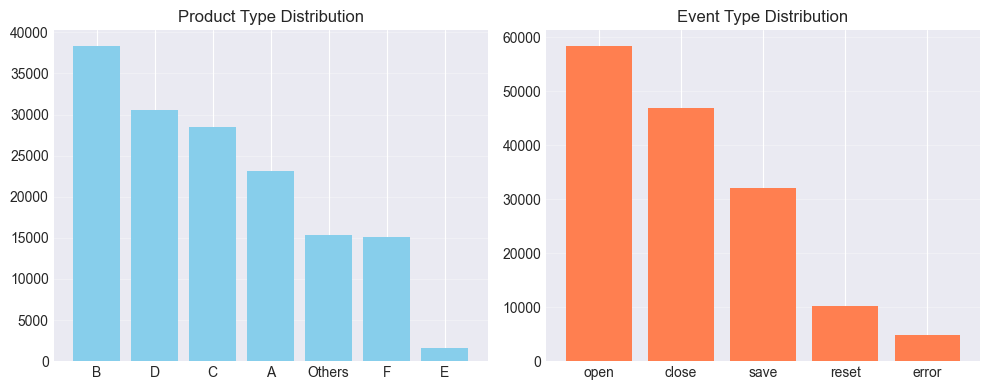

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

product_counts = df_raw["Product Type"].value_counts()
axes[0].bar(product_counts.index, product_counts.values, color="skyblue")
axes[0].set_title("Product Type Distribution")
axes[0].grid(axis="y", alpha=0.3)

event_counts = df_raw["Event Type"].value_counts()
axes[1].bar(event_counts.index, event_counts.values, color="coral")
axes[1].set_title("Event Type Distribution")
axes[1].grid(axis="y", alpha=0.3)
plt.tight_layout()

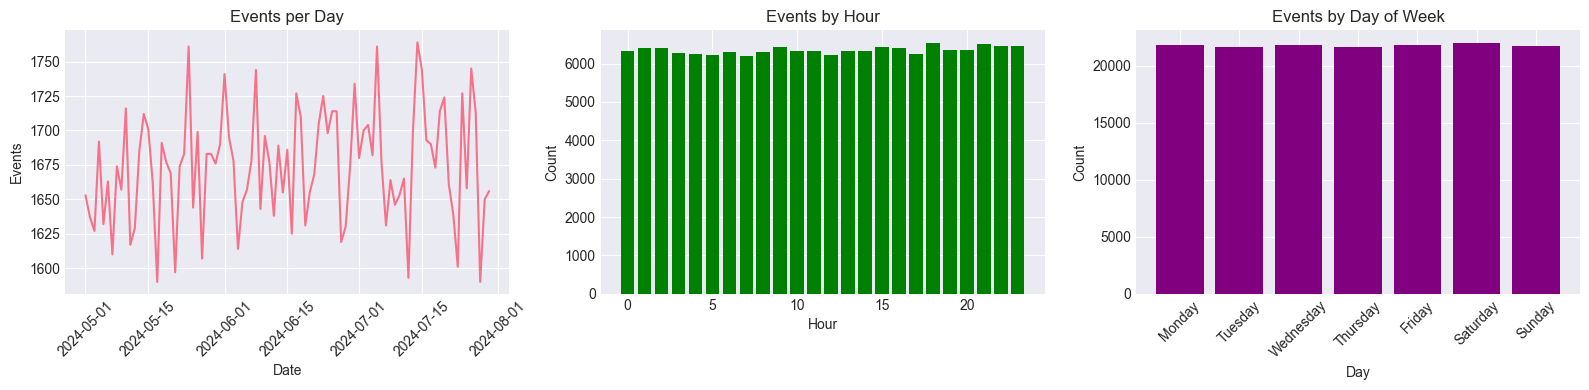

In [38]:
df_raw["Time of Event"] = pd.to_datetime(df_raw["Time of Event"])
df_raw["Date"] = df_raw["Time of Event"].dt.date
df_raw["Hour"] = df_raw["Time of Event"].dt.hour
df_raw["DayOfWeek"] = df_raw["Time of Event"].dt.day_name()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

daily_counts = df_raw.groupby("Date").size()
axes[0].plot(daily_counts.index, daily_counts.values)
axes[0].set_title("Events per Day")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Events")
axes[0].tick_params(axis="x", rotation=45)

hourly_counts = df_raw["Hour"].value_counts().sort_index()
axes[1].bar(hourly_counts.index, hourly_counts.values, color="green")
axes[1].set_title("Events by Hour")
axes[1].set_xlabel("Hour")
axes[1].set_ylabel("Count")

day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
dow_counts = df_raw["DayOfWeek"].value_counts().reindex(day_order)
axes[2].bar(dow_counts.index, dow_counts.values, color="purple")
axes[2].set_title("Events by Day of Week")
axes[2].set_xlabel("Day")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

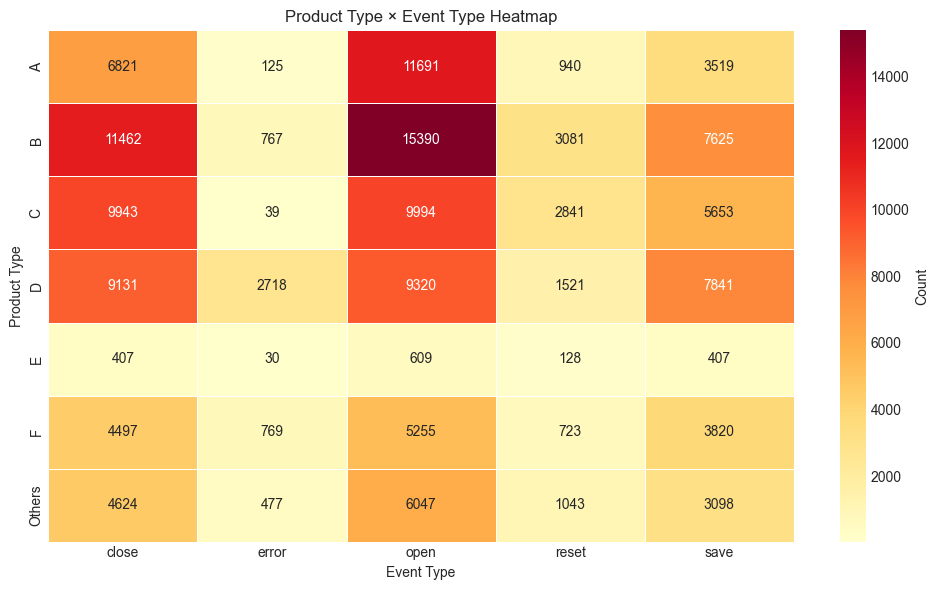

In [39]:
crosstab = pd.crosstab(df_raw["Product Type"], df_raw["Event Type"], margins=True)

plt.figure(figsize=(10, 6))
sns.heatmap(
    crosstab.iloc[:-1, :-1],
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={"label": "Count"},
)
plt.title("Product Type × Event Type Heatmap")
plt.xlabel("Event Type")
plt.ylabel("Product Type")
plt.tight_layout()
plt.show()

### 3. Data Preprocessing

We prepare the data for the VAE by:

1. Dropping the `User ID` column (not needed for modeling)
2. Converting timestamps to Unix seconds for numerical representation
3. One-hot encoding categorical variables
4. Standardizing numerical features


In [40]:
df = df_raw.copy()

df = df.drop(columns=["User ID"], errors="ignore")
df["TimeSeconds"] = pd.to_datetime(df["Time of Event"]).astype("int64") // 1_000_000_000
df["TimeOriginal"] = df["Time of Event"]

categorical_cols = ["Product Type", "Event Type"]
numeric_cols = ["TimeSeconds"]

df.head()

,Product Type,Event Type,Time of Event,Date,Hour,DayOfWeek,TimeSeconds,TimeOriginal
0,C,open,2024-05-14 07:34:33,2024-05-14,7,Tuesday,1715672073,2024-05-14 07:34:33
1,E,close,2024-06-17 14:43:26,2024-06-17,14,Monday,1718635406,2024-06-17 14:43:26
2,C,close,2024-07-13 05:20:43,2024-07-13,5,Saturday,1720848043,2024-07-13 05:20:43
3,D,open,2024-06-11 17:39:05,2024-06-11,17,Tuesday,1718127545,2024-06-11 17:39:05
4,C,save,2024-06-23 18:20:35,2024-06-23,18,Sunday,1719166835,2024-06-23 18:20:35


In [41]:
transformer = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            categorical_cols,
        ),
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="drop",
)

X_transformed = transformer.fit_transform(df[categorical_cols + numeric_cols])

In [42]:
X_train, X_test = train_test_split(X_transformed, test_size=0.2, random_state=42)
print(f"{X_train.shape}, {X_test.shape}")

(121884, 13), (30472, 13)


### 4. Dataset and DataLoader Setup


In [43]:
class TelemetryDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]


train_dataset = TelemetryDataset(X_train)
test_dataset = TelemetryDataset(X_test)

### 5. Model Architecture: Variational Autoencoder (VAE)

The VAE consists of an encoder network that transforms an input $\mathbf{x}$ into the parameters $\boldsymbol{\mu}$ and $\log \boldsymbol{\sigma}^2$ of a latent Gaussian distribution. A latent vector $\mathbf{z}$ is then sampled from the distribution $\mathcal{N}(\boldsymbol{\mu}, \operatorname{diag}(\boldsymbol{\sigma}^2))$, where the dimensionality of $\mathbf{z}$ is set to 8 by default. The decoder network takes $\mathbf{z}$ and reconstructs the input, producing an output $\hat{\mathbf{x}}$ that approximates the original data.

When training with DP-SGD, each per-sample gradient $\mathbf{g}_i$ is clipped so that its $\ell_2$-norm does not exceed a threshold $C$. Gaussian noise, drawn from the distribution $\mathcal{N}(0, \sigma^2 C^2 I)$, is then added to the aggregated gradients to provide differential privacy guarantees.

In [44]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8, hidden_dims=[64, 32]):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.extend(
                [nn.Linear(prev_dim, h_dim), nn.ReLU(), nn.BatchNorm1d(h_dim)]
            )
            prev_dim = h_dim

        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.extend(
                [nn.Linear(prev_dim, h_dim), nn.ReLU(), nn.BatchNorm1d(h_dim)]
            )
            prev_dim = h_dim

        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train.shape[1]
model = VAE(input_dim=input_dim, latent_dim=8, hidden_dims=[64, 32]).to(device)

model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_mu): Linear(in_features=32, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=13, bias=True)
  )
)

In [45]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + beta * kl_div
    
    return total_loss, recon_loss, kl_div

### 6. Differential Privacy Setup with Opacus

The key privacy parameters are $\epsilon$, which controls the privacy loss (lower values mean stronger privacy); $\delta$, which represents the probability of a privacy failure and is typically much less than $1/n$; the maximum gradient norm $C$, which limits the gradients during training; and the noise multiplier $\sigma$, which determines the scale of the Gaussian noise added. We track the privacy budget using Opacus's privacy accountant.

In [46]:
TARGET_EPSILON = 8.0
TARGET_DELTA = 1e-5
MAX_GRAD_NORM = 1.0
BATCH_SIZE = 256
EPOCHS = 50

In [47]:
model = ModuleValidator.fix(model)
model = model.to(device)

In [48]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [49]:
privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=0.57,
    max_grad_norm=MAX_GRAD_NORM,
)

c:\Users\Jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


### 7. Training Loop with Privacy Tracking

In [50]:
def train_epoch(model, train_loader, optimizer, device, beta=1.0):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    n_batches = 0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(batch)
        loss, recon_loss, kl_loss = vae_loss_function(
            recon_batch, batch, mu, logvar, beta
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        n_batches += 1

    return (
        total_loss / n_batches,
        total_recon_loss / n_batches,
        total_kl_loss / n_batches,
    )


def evaluate(model, test_loader, device, beta=1.0):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    n_batches = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            recon_batch, mu, logvar = model(batch)
            loss, recon_loss, kl_loss = vae_loss_function(
                recon_batch, batch, mu, logvar, beta
            )

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            n_batches += 1

    return (
        total_loss / n_batches,
        total_recon_loss / n_batches,
        total_kl_loss / n_batches,
    )

In [51]:
history = {
    "train_loss": [],
    "train_recon": [],
    "train_kl": [],
    "test_loss": [],
    "test_recon": [],
    "test_kl": [],
    "epsilon": [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_recon, train_kl = train_epoch(
        model, train_loader, optimizer, device
    )
    test_loss, test_recon, test_kl = evaluate(model, test_loader, device)

    epsilon = privacy_engine.get_epsilon(delta=TARGET_DELTA)

    history["train_loss"].append(train_loss)
    history["train_recon"].append(train_recon)
    history["train_kl"].append(train_kl)
    history["test_loss"].append(test_loss)
    history["test_recon"].append(test_recon)
    history["test_kl"].append(test_kl)
    history["epsilon"].append(epsilon)

    if epoch % 5 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d}/{EPOCHS} | "
            f"Train loss: {train_loss:8.2f} | "
            f"Test loss: {test_loss:8.2f} | "
            f"ε: {epsilon:.2f}"
        )

print(f"Final ε: {history['epsilon'][-1]:.4f} (target: {TARGET_EPSILON})")
print(f"Final δ: {TARGET_DELTA}")

C:\Users\Jason\AppData\Local\Temp\ipykernel_11140\4091954141.py:18: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Epoch   1/50 | Train loss:   660.30 | Test loss:   643.58 | ε: 2.55
Epoch   5/50 | Train loss:   650.98 | Test loss:   644.14 | ε: 3.55
Epoch  10/50 | Train loss:   650.28 | Test loss:   643.79 | ε: 4.29
Epoch  15/50 | Train loss:   648.25 | Test loss:   644.02 | ε: 4.90
Epoch  20/50 | Train loss:   649.57 | Test loss:   645.75 | ε: 5.44
Epoch  25/50 | Train loss:   645.03 | Test loss:   643.67 | ε: 5.94
Epoch  30/50 | Train loss:   648.58 | Test loss:   643.50 | ε: 6.40
Epoch  35/50 | Train loss:   645.76 | Test loss:   643.50 | ε: 6.83
Epoch  40/50 | Train loss:   644.21 | Test loss:   644.30 | ε: 7.25
Epoch  45/50 | Train loss:   645.22 | Test loss:   643.20 | ε: 7.65
Epoch  50/50 | Train loss:   649.67 | Test loss:   643.33 | ε: 8.04
Final ε: 8.0364 (target: 8.0)
Final δ: 1e-05


### 8. Training Visualization

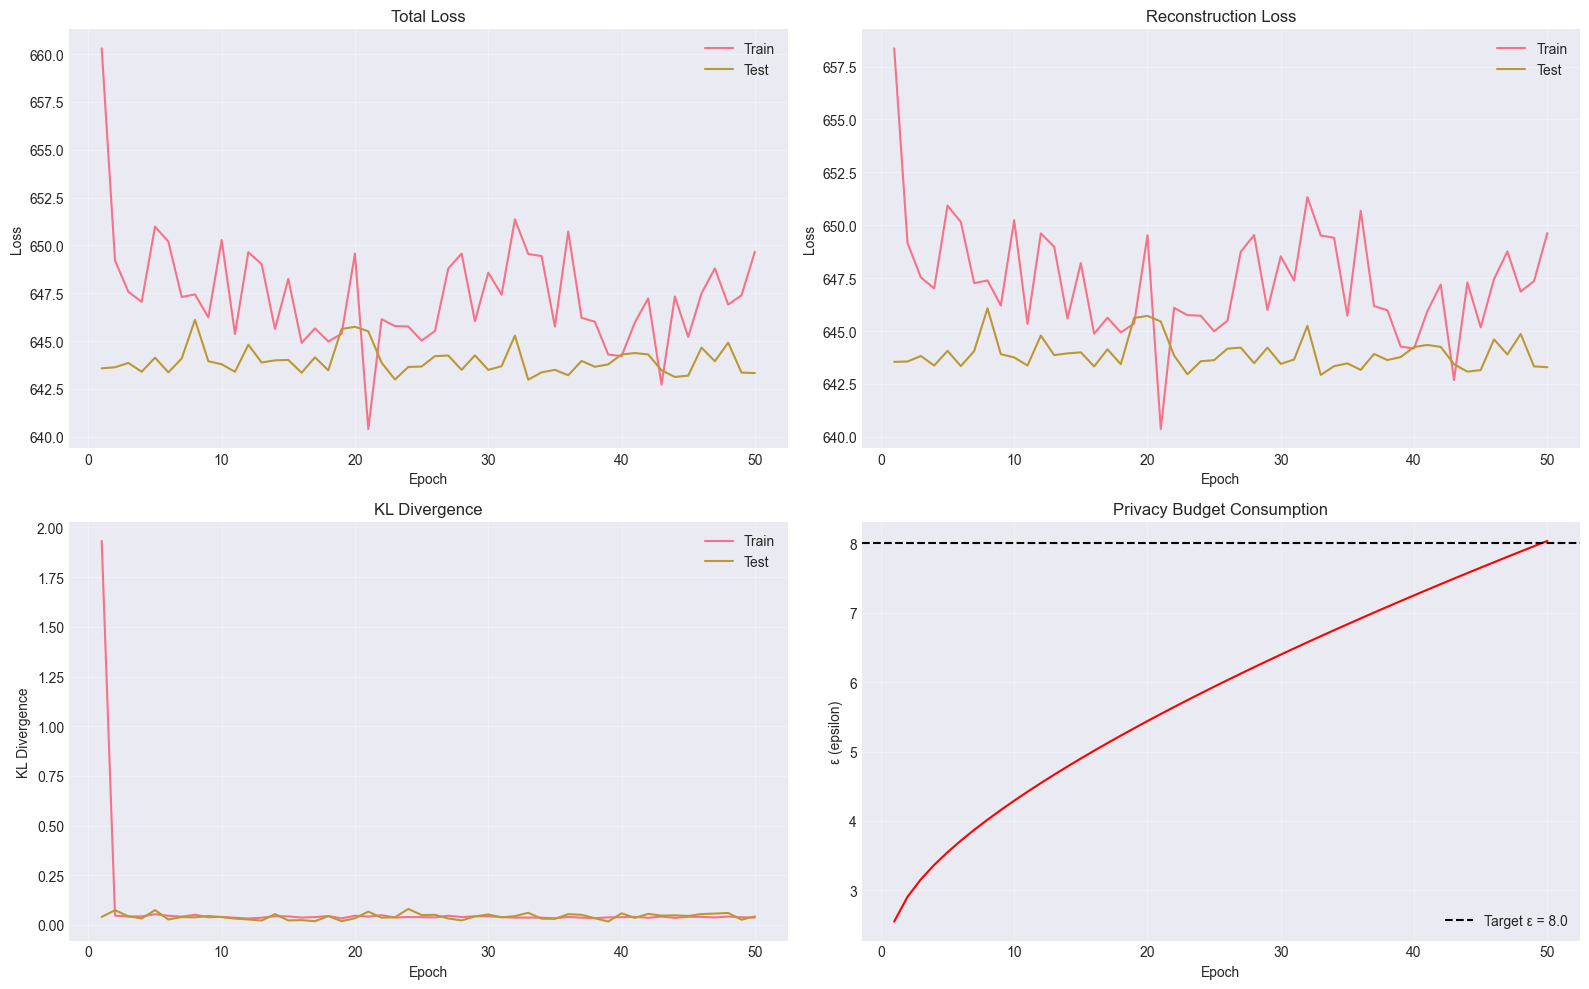

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

epochs_range = range(1, EPOCHS + 1)

axes[0, 0].plot(epochs_range, history['train_loss'], label='Train')
axes[0, 0].plot(epochs_range, history['test_loss'], label='Test')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(epochs_range, history['train_recon'], label='Train')
axes[0, 1].plot(epochs_range, history['test_recon'], label='Test')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(epochs_range, history['train_kl'], label='Train')
axes[1, 0].plot(epochs_range, history['test_kl'], label='Test')
axes[1, 0].set_title('KL Divergence')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('KL Divergence')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(epochs_range, history['epsilon'], color='red')
axes[1, 1].axhline(y=TARGET_EPSILON, color='black', linestyle='--', label=f'Target ε = {TARGET_EPSILON}')
axes[1, 1].set_title('Privacy Budget Consumption')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('ε (epsilon)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 9. Generate Synthetic Data

In [ ]:
def generate_synthetic_samples(model, n_samples, device):
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_dim).to(device)
        synthetic = model.decode(z)
    
    return synthetic.cpu().numpy()

n_synthetic = len(df_raw)
X_synthetic = generate_synthetic_samples(model, n_synthetic, device)

print(f"✓ Generated {n_synthetic:,} synthetic samples")
print(f"  - Shape: {X_synthetic.shape}")
print(f"  - Type: {X_synthetic.dtype}")
print(f"\nSynthetic data statistics:")
print(f"  - Mean: {X_synthetic.mean():.4f}")
print(f"  - Std: {X_synthetic.std():.4f}")
print(f"  - Min: {X_synthetic.min():.4f}")
print(f"  - Max: {X_synthetic.max():.4f}")